#Importing Libraries

In [ ]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from sklearn.preprocessing importinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

warnings.filterwarnings('ignore')

#Loading Datasets, Adding a SoC column in each and then Combining the datasets

In [ ]:
folder_path = "/content/drive/MyDrive/nvm"
all_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx')])
datasets = {}

for file in all_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    # Extract SOC value from filename (e.g., '20SOC.xlsx')
    soc_match = re.search(r'(\d+)SOC', file)
    if soc_match:
        df["SOC"] = int(soc_match.group(1))
    datasets[file] = df

print(f"Loaded {len(datasets)} datasets successfully!")
for name, df in datasets.items():
    print(f"\nDataset: {name}")
    print(df.head(), "\n")

Loaded 6 datasets successfully!

Dataset: SNL_NMC-LMO_Graphite_26Ah_100SOC_b.xlsx
   Test Time [s]  Displacement [mm]  Penetrator Force [mm]  vCell [V]  \
0           1.06             -0.055                  4.900      4.132   
1           2.06             -0.085                  3.503      4.132   
2           3.06             -0.009                  0.377      4.132   
3           4.06             -0.130                  5.765      4.132   
4           5.06             -0.124                  4.330      4.132   

   tAmbient [C]  TC1 near positive terminal [C]  \
0          19.5                            20.3   
1          19.5                            20.4   
2          19.5                            20.3   
3          19.5                            20.4   
4          19.4                            20.4   

   TC2 near negative terminal [C]  TC3 bottom - bottom [C]  \
0                            20.0                     20.2   
1                            20.0               

In [ ]:
combined_df = pd.concat(datasets.values(), ignore_index=True)
print("Combined Dataset Preview:")
print(combined_df.head())


Combined Dataset Preview:
   Test Time [s]  Displacement [mm]  Penetrator Force [mm]  vCell [V]  \
0           1.06             -0.055                  4.900      4.132   
1           2.06             -0.085                  3.503      4.132   
2           3.06             -0.009                  0.377      4.132   
3           4.06             -0.130                  5.765      4.132   
4           5.06             -0.124                  4.330      4.132   

   tAmbient [C]  TC1 near positive terminal [C]  \
0          19.5                            20.3   
1          19.5                            20.4   
2          19.5                            20.3   
3          19.5                            20.4   
4          19.4                            20.4   

   TC2 near negative terminal [C]  TC3 bottom - bottom [C]  \
0                            20.0                     20.2   
1                            20.0                     20.2   
2                            20.0         

#Data Cleaning

In [ ]:
combined_df.isnull().sum()

,0
Test Time [s],0
Displacement [mm],0
Penetrator Force [mm],0
vCell [V],0
tAmbient [C],0
TC1 near positive terminal [C],0
TC2 near negative terminal [C],0
TC3 bottom - bottom [C],0
TC4 bottom - top [C],0
TC5 above punch [C],0


In [ ]:
combined_df.duplicated().sum()

np.int64(0)

# Creating a target variable to define thermal runaway based on a threshold (120 in °C)

In [ ]:
TEMP_THRESHOLD = 80          # Celsius
TEMP_RISE_THRESHOLD = 10     # Celsius difference for a sudden rise
VOLTAGE_DROP_THRESHOLD = 3.0 # Volts

# List of temperature sensor columns
temp_cols = [
    'TC1 near positive terminal [C]',
    'TC2 near negative terminal [C]',
    'TC3 bottom - bottom [C]',
    'TC4 bottom - top [C]',
    'TC5 above punch [C]',
    'TC6 below punch [C]'
]

# Compute the maximum temperature across the sensors at each time step
combined_df['Max_Temp'] = combined_df[temp_cols].max(axis=1)

# Compute the difference (rise) in maximum temperature between consecutive time steps
combined_df['Max_Temp_Diff'] = combined_df['Max_Temp'].diff()

# Compute the conditions:
# - Maximum temperature exceeds the threshold or the sudden rise exceeds the threshold
# - AND the cell voltage is below the voltage drop threshold
combined_df['Thermal_Runaway'] = (
    ((combined_df['Max_Temp'] >= TEMP_THRESHOLD) |
     (combined_df['Max_Temp_Diff'] >= TEMP_RISE_THRESHOLD)) &
    (combined_df["vCell [V]"] < VOLTAGE_DROP_THRESHOLD)
).astype(int)

# Preview the Thermal_Runaway column
print("\nThermal Runaway Column Preview:")
print(combined_df[['Thermal_Runaway']].head())


Thermal Runaway Column Preview:
   Thermal_Runaway
0                0
1                0
2                0
3                0
4                0


In [ ]:
# Inspect rows with thermal runaway
thermal_runaway_df = combined_df[combined_df['Thermal_Runaway'] == 1]
print("\nSamples with Thermal Runaway (if any):")
print(thermal_runaway_df.head())


Samples with Thermal Runaway (if any):
     Test Time [s]  Displacement [mm]  Penetrator Force [mm]  vCell [V]  \
336         337.06              6.397                 62.290      3.858   
337         338.06              6.379                 19.593      3.907   
338         339.06              6.580                 15.290      3.933   
339         340.06              6.490                 11.005      3.917   
340         341.06              6.605                  5.746      3.906   

     tAmbient [C]  TC1 near positive terminal [C]  \
336          19.6                            48.3   
337          19.6                            94.7   
338          19.6                           155.2   
339          19.9                           192.2   
340          20.1                           212.8   

     TC2 near negative terminal [C]  TC3 bottom - bottom [C]  \
336                            22.7                     22.1   
337                            25.7                     26.9  

In [ ]:
print(combined_df.columns)


Index(['Test Time [s]', 'Displacement [mm]', 'Penetrator Force [mm]',
       'vCell [V]', 'tAmbient [C]', 'TC1 near positive terminal [C]',
       'TC2 near negative terminal [C]', 'TC3 bottom - bottom [C]',
       'TC4 bottom - top [C]', 'TC5 above punch [C]', 'TC6 below punch [C]',
       'SOC', 'Thermal_Runaway'],
      dtype='object')


#Splitting the dataset

In [ ]:
feature_cols = ['Displacement [mm]', 'Penetrator Force [mm]', 'vCell [V]', 'tAmbient [C]',
                'TC1 near positive terminal [C]', 'TC2 near negative terminal [C]',
                'TC3 bottom - bottom [C]', 'TC4 bottom - top [C]',
                'TC5 above punch [C]', 'TC6 below punch [C]']

# Define X and y (without scaling yet)
X = combined_df[feature_cols].values
y = combined_df['Thermal_Runaway'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Feature Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN-LSTM (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the CNN-LSTM Model

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 32)               │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          16,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,617 (72.72 KB)

 Trainable params: 18,617 (72.72 KB)

 Non-trainable params: 0 (0.00 B)

##Training the model

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=16, validation_data=(X_test_scaled, y_test))

Epoch 1/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9690 - loss: 0.1608 - val_accuracy: 0.9975 - val_loss: 0.0063
Epoch 2/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9959 - loss: 0.0121 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 3/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9965 - loss: 0.0079 - val_accuracy: 0.9982 - val_loss: 0.0044
Epoch 4/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9982 - val_loss: 0.0042
Epoch 5/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9973 - loss: 0.0071 - val_accuracy: 0.9988 - val_loss: 0.0025
Epoch 6/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9974 - loss: 0.0064 - val_accuracy: 0.9988 - val_loss: 0.0033
Epoch 7/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9973 - loss: 0.0070 - val_accuracy: 0.9982 - val_loss: 0.0035
Epoch 8/20
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9979 - loss: 0.005

##Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0060

Test Loss: 0.0050, Test Accuracy: 0.9975


##Plot Training History

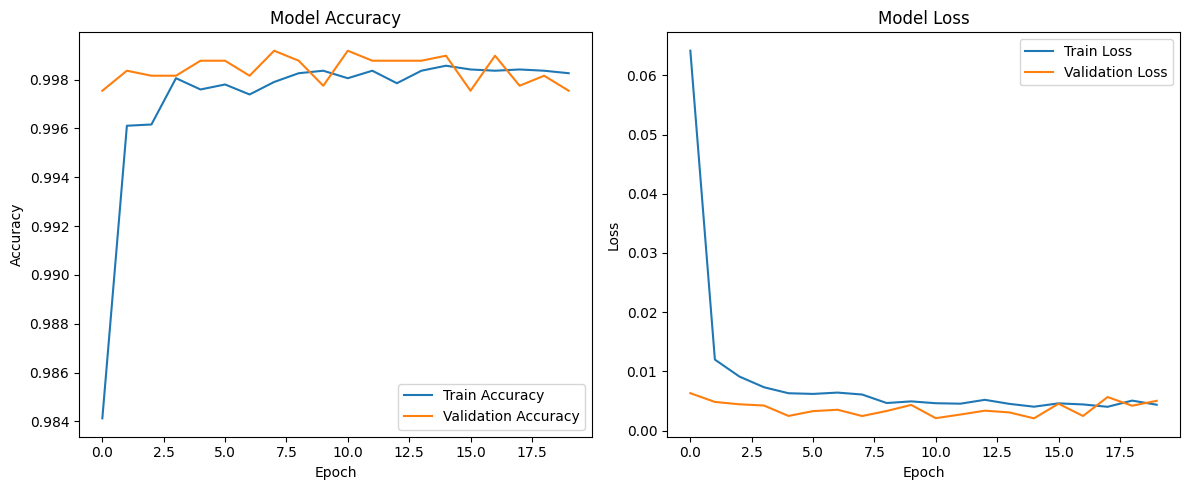

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Performance Metrics

In [ ]:
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


##Confusion Matrix

Confusion Matrix:
[[4660   12]
 [   0  210]]


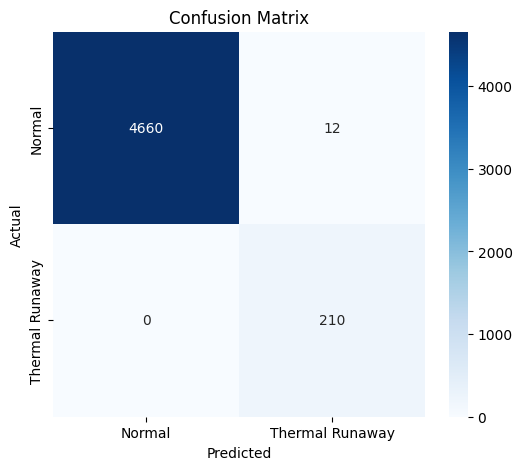

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Thermal Runaway'], yticklabels=['Normal', 'Thermal Runaway'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##Classification Report

In [ ]:
cr = classification_report(y_test, y_pred, target_names=['Normal', 'Thermal Runaway'])
print("Classification Report:")
print(cr)

Classification Report:
                 precision    recall  f1-score   support

         Normal       1.00      1.00      1.00      4672
Thermal Runaway       0.95      1.00      0.97       210

       accuracy                           1.00      4882
      macro avg       0.97      1.00      0.99      4882
   weighted avg       1.00      1.00      1.00      4882



##ROC Curve and AUC

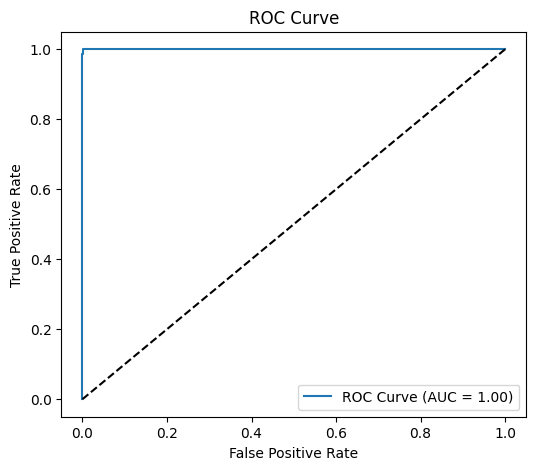

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Saving the Model

In [ ]:
model.save('thermal_runaway_model.h5')
model = load_model('thermal_runaway_model.h5')
print("Model saved and reloaded successfully.")


Model saved and reloaded successfully.
